In [2]:
import qutip as qt 
import qutipext as qte
import numpy as np
import matplotlib.pyplot as plt
import scipy
from functools import partial
from tensoresprit.Experiment import Experiment
from tensoresprit.Extractor import Extractor

In [3]:
def f(x): return qte.Lattice("Chain",1,x,np.array([[8.7,0]]))
xs = np.arange(10)

res = qt.parallel_map(f, xs)
print(res)

[<qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddfad0>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddfd90>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaed19910>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddc8d0>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddc110>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddca50>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddff10>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddc1d0>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddc990>, <qutipext.hamiltonian_extension.Lattice object at 0x7f9aaeddc5d0>]


In [9]:
N = 1
lattice = qte.Lattice("Chain",1,N,np.array([[8.7,0]]))

In [10]:
lattice.positions

array([[0., 0.]])

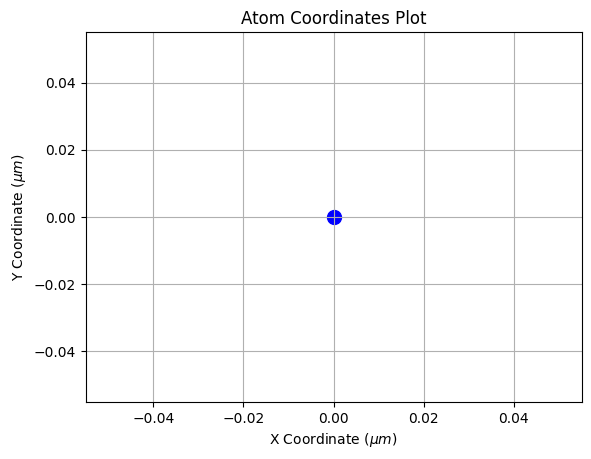

In [6]:
qte.plot_positions(lattice.positions)

In [1]:
V = qte.Interaction(lattice)
Detune = -(2*np.pi*2)*qte.Global_Detuning(lattice)
Rabi = (2*np.pi*2)*qte.Global_X(lattice)
Local_Detune = qte.Local_Detuning(lattice, np.random.rand((N)))

NameError: name 'qte' is not defined

In [239]:
def pulse(index, t, t_pulse):
    return V + Detune + Rabi + qte.Local_Detuning(lattice, [50 * np.sin(2 * np.pi * index * t / t_pulse), 0])
    #return V + Detune + Rabi + index * Local_Detune

H_const = V + Detune + Rabi + Local_Detune
dim = (2**N)**2

Ls = []

for i in range(dim):
    H_const = V + Detune + Rabi + np.sqrt(i) * qte.Local_Detuning(lattice, [1, 0])
    Ls.append(qt.liouvillian(H_const))

t_pulse = 100.
state = np.zeros(dim,dtype=complex)
state[0] = 1
states = []
obs = []
for i in range(2**N):
    bitstring = [i%2,0]
    print(bitstring)
    state = qte.bitstring_state(bitstring)*qte.bitstring_state(bitstring).dag()
    states.append(qt.operator_to_vector(state).full())
    obs.append(qt.operator_to_vector(qte.PauliString([i,0])).full())

state = qte.bitstring_state([0 for i in range(N)])
rho_0 = qt.operator_to_vector(state * state.dag()).full()
obs = qt.operator_to_vector(qte.PauliString([3,0])).full()
obs_id = qt.operator_to_vector(qte.PauliString([0,0])).full()
mat = np.zeros((dim,dim),dtype=complex)
for i, L_init in enumerate(Ls):
    for j, L_fin in enumerate(Ls):
        #mat[i,j] = obs[j%4].conj().T @ scipy.linalg.expm(t_pulse*L_fin.full()) @ scipy.linalg.expm(t_pulse*L_init.full()) @ states[i%4]
        if j == dim-1:
            mat[i,j] = obs_id.conj().T @ scipy.linalg.expm(t_pulse*L_fin.full()) @ scipy.linalg.expm(t_pulse*L_init.full()) @ rho_0
        else:
            mat[i,j] = obs.conj().T @ scipy.linalg.expm(t_pulse*L_fin.full()) @ scipy.linalg.expm(t_pulse*L_init.full()) @ rho_0
evals, _ = np.linalg.eig(mat)
print(np.sort(np.abs(evals)))

def H(i, j, t, t_free, t_pulse):
    if t < t_pulse:
        return pulse(i, t, t_pulse)
    elif t < t_pulse + t_free:
        return H_const
    else:
        return pulse(j, t, t_pulse)

[0, 0]
[1, 0]
[0, 0]
[1, 0]
[1.08845364e-05 2.09871931e-03 2.19748402e-03 1.90698252e-02
 1.95296326e-02 1.95296326e-02 2.61021555e-02 8.08530461e-02
 1.16386441e-01 1.16386441e-01 1.73934041e-01 1.40852026e+00
 1.52210441e+00 2.22268131e+00 5.14157634e+00 5.26270578e+00]


In [240]:
delta = 0.02
no_samples = 50
times = delta * np.arange(no_samples)
t_pulse = 100.

In [ ]:
#H = V + Detune + Rabi + Local_Detune

measured_data = np.zeros((no_samples, dim, dim))

rho0 = qte.bitstring_state([0 for i in range(N)])*qte.bitstring_state([0 for i in range(N)]).dag()
observable = qte.PauliString([3,0])

c_ops = []
#Gamma1 = 0.1
#Gamma2 = 0.05
#for i in range(N):
#    tmp = [qt.qeye(2) for j in range(N)]
#    tmp[i] = qt.sigmam()
#    c_ops.append([np.sqrt(Gamma1)*qt.tensor(tmp),"1"])
#    c_ops.append([np.sqrt(Gamma2)*qt.tensor(tmp),"np.sqrt(t)"])

for i in range(dim):
    for j in range(dim):
        print(i,j)
        for k, t_free in enumerate(times):
            H_current = qt.QobjEvo(lambda t: H(i, j, t, t_free, t_pulse))
            total_time = 2*t_pulse + t_free
            solver_times = np.linspace(0,total_time,100)
            result = qt.mesolve(H_current, rho0, solver_times, c_ops, observable).expect[0][-1]
            measured_data[k, i, j] = result

0 0


In [148]:
print(np.linalg.eig(measured_data[0,:,:]))
print(measured_data.shape)
data = Experiment(measured_data, no_samples, delta)

solverParams = {'mode':'oscillation'}
extractor = Extractor(data, solver="tensorESPRIT", solverParams=solverParams)
extractor.extract()

(array([-7.69264615e-01, -1.47451574e-04,  1.78171047e+00,  1.40109419e+00]), array([[-0.72136734, -0.44077368, -0.34717692, -0.40651163],
       [-0.62706411,  0.1224961 ,  0.33930319,  0.69060964],
       [ 0.26805776, -0.6048505 , -0.47169543,  0.58257258],
       [-0.1206847 ,  0.65181986, -0.73610119,  0.13570488]]))
(50, 4, 4)


In [149]:
true_spectrum,_ = np.linalg.eig(qt.liouvillian(H_const).full())
true_spectrum = np.sort((-1j*true_spectrum).real)
recovered_spectrum,_ = np.linalg.eig(extractor.noisyGeneratorEstimate())
recovered_spectrum = np.sort(recovered_spectrum.real)
print(np.linalg.norm(true_spectrum - recovered_spectrum) / np.linalg.norm(true_spectrum))
print(true_spectrum)
print(recovered_spectrum.real)

0.07513130880585803
[-1.47081538e+01 -4.04658510e-16  1.24342992e-16  1.47081538e+01]
[-1.36031109e+01 -3.39906415e-16  1.66070885e-16  1.36031109e+01]
